### 09-3. LSTM과 GRU 셀

##### 1) LSTM 신경망 훈련하기

In [1]:
# 데이터 로드 후 train set과 validation set 으로 나누기

from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, random_state=42, test_size=0.2)

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant t

In [2]:
# 샘플 길이를 100으로 맞추고 부족하면 패딩

from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

In [3]:
# LSTM 셀을 사용한 순환층 생성

from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.Embedding(500, 16, input_length=100))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation="sigmoid"))

In [4]:
# 모델 구조 출력

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           8000      
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 8,809
Trainable params: 8,809
Non-trainable params: 0
_________________________________________________________________


In [5]:
# 모델 훈련

rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss="binary_crossentropy", metrics=["accuracy"])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 6s 18ms/step - loss: 0.6923 - accuracy: 0.5419 - val_loss: 0.6917 - val_accuracy: 0.5632
Epoch 2/100
313/313 [==============================] - 5s 16ms/step - loss: 0.6899 - accuracy: 0.6054 - val_loss: 0.6881 - val_accuracy: 0.6168
Epoch 3/100
313/313 [==============================] - 5s 16ms/step - loss: 0.6826 - accuracy: 0.6570 - val_loss: 0.6748 - val_accuracy: 0.6816s - l
Epoch 4/100
313/313 [==============================] - 5s 16ms/step - loss: 0.6423 - accuracy: 0.7114 - val_loss: 0.6120 - val_accuracy: 0.6964
Epoch 5/100
313/313 [==============================] - 5s 16ms/step - loss: 0.5936 - accuracy: 0.7157 - val_loss: 0.5846 - val_accuracy: 0.7208- loss: 0.597 - ETA: 0s - loss: 0.5945 
Epoch 6/100
313/313 [==============================] - 5s 17ms/step - loss: 0.5700 - accuracy: 0.7340 - val_loss: 0.5624 - val_accuracy: 0.7424
Epoch 7/100
313/313 [==============================] - 5s 17ms/step - loss: 0.5475 - accurac

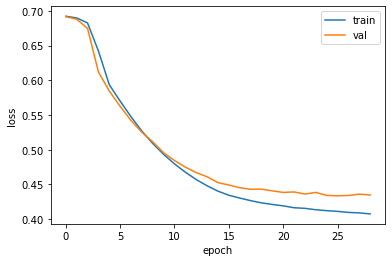

In [6]:
# 훈련 손실과 검증 손실 그래프

import matplotlib.pyplot as plt

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train","val"])
plt.show()

##### 2) 순환층에 드롭아웃 적용하기 - 과대적합 제어 #####

In [7]:
# 드롭아웃 : 은닉층의 뉴런의 출력을 랜덤하게 꺼서 과대적합을 막는 기법
# dropout 셀의 입력에 드롭아웃 적용 / recurrent_dropout : 순환되는 은닉 상태에 드롭아웃 적용, 단 GPU를 사용하여 모델 훈련이 불가하게 됨

# dropout 만 적용하기

model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.LSTM(8, dropout=0.3))
model2.add(keras.layers.Dense(1, activation="sigmoid"))

In [8]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-dropout-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model2.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 6s 20ms/step - loss: 0.6925 - accuracy: 0.5235 - val_loss: 0.6917 - val_accuracy: 0.5614
Epoch 2/100
313/313 [==============================] - 5s 16ms/step - loss: 0.6898 - accuracy: 0.5986 - val_loss: 0.6878 - val_accuracy: 0.6216
Epoch 3/100
313/313 [==============================] - 5s 17ms/step - loss: 0.6799 - accuracy: 0.6637 - val_loss: 0.6650 - val_accuracy: 0.7046
Epoch 4/100
313/313 [==============================] - 5s 16ms/step - loss: 0.6342 - accuracy: 0.7008 - val_loss: 0.6142 - val_accuracy: 0.6994
Epoch 5/100
313/313 [==============================] - 5s 16ms/step - loss: 0.6035 - accuracy: 0.7026 - val_loss: 0.5919 - val_accuracy: 0.7132
Epoch 6/100
313/313 [==============================] - 6s 18ms/step - loss: 0.5822 - accuracy: 0.7186 - val_loss: 0.5725 - val_accuracy: 0.7236
Epoch 7/100
313/313 [==============================] - 5s 17ms/step - loss: 0.5601 - accuracy: 0.7390 - val_loss: 0.5518 - val_accuracy:

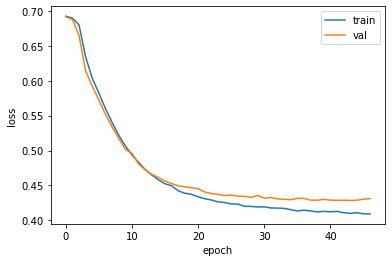

In [9]:
# 훈련 손실 및 검증 손실 그래프

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "val"])
plt.show() # 훈련손실과 검증손실의 격차 줄어듦 확인

##### 3) 2개의 층 연결 #####

In [10]:
# 순환층을 연결하기 위해서는 앞쪽의 순환층이 모든 타임스텝에 대한 은닉 상태를 출력해야 함 -> return_sequences=True 로 설정
# 2개의 LSTM층 쌓기

model3 = keras.Sequential()
model3.add(keras.layers.Embedding(500, 16, input_length=100))
model3.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True))
model3.add(keras.layers.LSTM(8, dropout=0.3))
model3.add(keras.layers.Dense(1, activation="sigmoid"))

In [11]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 16)           8000      
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 8)            800       
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 9,353
Trainable params: 9,353
Non-trainable params: 0
_________________________________________________________________


In [12]:
# 모델 훈련

rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model3.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-2rnn-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model2.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 6s 20ms/step - loss: 0.4103 - accuracy: 0.8134 - val_loss: 0.4286 - val_accuracy: 0.8028
Epoch 2/100
313/313 [==============================] - 6s 18ms/step - loss: 0.4107 - accuracy: 0.8107 - val_loss: 0.4279 - val_accuracy: 0.8006
Epoch 3/100
313/313 [==============================] - 6s 19ms/step - loss: 0.4112 - accuracy: 0.8130 - val_loss: 0.4281 - val_accuracy: 0.7998
Epoch 4/100
313/313 [==============================] - 5s 16ms/step - loss: 0.4099 - accuracy: 0.8120 - val_loss: 0.4289 - val_accuracy: 0.8020
Epoch 5/100
313/313 [==============================] - 5s 17ms/step - loss: 0.4075 - accuracy: 0.8127 - val_loss: 0.4302 - val_accuracy: 0.8018


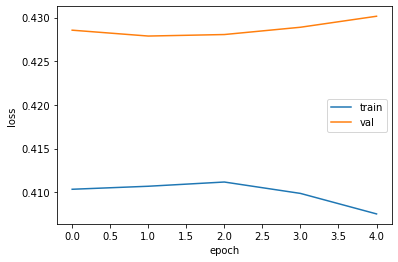

In [13]:
# 훈련 손실 검증 손실 그래프

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "val"])
plt.show()

### GRU 구조 ###

In [14]:
model4 = keras.Sequential()
model4.add(keras.layers.Embedding(500, 16, input_length=100))
model4.add(keras.layers.GRU(8))
model4.add(keras.layers.Dense(1, activation="sigmoid"))

In [16]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 16)           8000      
_________________________________________________________________
gru (GRU)                    (None, 8)                 624       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 8,633
Trainable params: 8,633
Non-trainable params: 0
_________________________________________________________________


In [27]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model4.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-gru-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model4.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 6s 20ms/step - loss: 0.6898 - accuracy: 0.5840 - val_loss: 0.6888 - val_accuracy: 0.5856
Epoch 2/100
313/313 [==============================] - 6s 20ms/step - loss: 0.6863 - accuracy: 0.5976 - val_loss: 0.6849 - val_accuracy: 0.6022
Epoch 3/100
313/313 [==============================] - 6s 20ms/step - loss: 0.6808 - accuracy: 0.6166 - val_loss: 0.6787 - val_accuracy: 0.6096
Epoch 4/100
313/313 [==============================] - 6s 19ms/step - loss: 0.6722 - accuracy: 0.6322 - val_loss: 0.6689 - val_accuracy: 0.6256
Epoch 5/100
313/313 [==============================] - 6s 19ms/step - loss: 0.6578 - accuracy: 0.6505 - val_loss: 0.6514 - val_accuracy: 0.6482
Epoch 6/100
313/313 [==============================] - 6s 19ms/step - loss: 0.6306 - accuracy: 0.6712 - val_loss: 0.6166 - val_accuracy: 0.6772
Epoch 7/100
313/313 [==============================] - 6s 19ms/step - loss: 0.5794 - accuracy: 0.7106 - val_loss: 0.5624 - val_accuracy:

313/313 [==============================] - 6s 19ms/step - loss: 0.4095 - accuracy: 0.8190 - val_loss: 0.4488 - val_accuracy: 0.7938


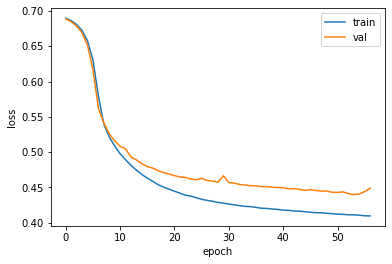

In [31]:
# 훈련손실 검증손실 그래프

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "val"])
plt.show()

##### 2) 2개 순환층 모델 성능 계산

In [32]:
test_seq = pad_sequences(test_input, maxlen=100)
rnn_model = keras.models.load_model('best-2rnn-model.h5')
rnn_model.evaluate(test_seq, test_target)

782/782 [==============================] - 2s 3ms/step - loss: 0.4262 - accuracy: 0.8033


[0.42624014616012573, 0.8033199906349182]